# Train the Generative Model for Candidate Labeling

This notebook is designed to run a generative model that snorkel uses to probabilistically label each candidate. (1 for positive label and -1 for negative label). Using this generative model, we will test the hypothesis: **modeling correlation structure between label functions provides better precision and recall than the conditionally independent model.**

## MUST RUN AT THE START OF EVERYTHING

Import the necessary modules and set up the database for database operations.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from collections import Counter, OrderedDict, defaultdict
import os
import tqdm

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import average_precision_score, precision_recall_curve, roc_curve, auc, f1_score

In [2]:
#Set up the environment
username = "danich1"
password = "snorkel"
dbname = "pubmeddb"

#Path subject to change for different os
database_str = "postgresql+psycopg2://{}:{}@/{}?host=/var/run/postgresql".format(username, password, dbname)
os.environ['SNORKELDB'] = database_str

from snorkel import SnorkelSession
session = SnorkelSession()

In [3]:
from snorkel import SnorkelSession
from snorkel.annotations import load_gold_labels
from snorkel.annotations import FeatureAnnotator, LabelAnnotator, save_marginals
from snorkel.learning import GenerativeModel
from snorkel.learning.structure import DependencySelector
from snorkel.learning.utils import MentionScorer
from snorkel.models import Candidate, FeatureKey, candidate_subclass, Label
from snorkel.utils import get_as_dict
from utils.disease_gene_lf import LFS

In [4]:
edge_type = "dg"

In [5]:
if edge_type == "dg":
    DiseaseGene = candidate_subclass('DiseaseGene', ['Disease', 'Gene'])
elif edge_type == "gg":
    GeneGene = candidate_subclass('GeneGene', ['Gene1', 'Gene2'])
elif edge_type == "cg":
    CompoundGene = candidate_subclass('CompoundGene', ['Compound', 'Gene'])
elif edge_type == "cd":
    CompoundDisease = candidate_subclass('CompoundDisease', ['Compound', 'Disease'])
else:
    print("Please pick a valid edge type")

# Load preprocessed data 

This code will load the corresponding label matricies that were generated in the previous notebook ([Notebook 2](2.data-labeler.ipynb)). This notebook has three matricies which are broken down as follows:

|Dataset|Size|Description|
|:-----|-----|:-----|
|L_train|50,000|Randomly sampled from our 2,700,000 training set|
|L_dev|10,000|Randomly sampled from our 700,000 dev set. Only 200 have been hand labeled|
|L_train_labeled|919|Have been hand labled from training set and is separate from (L_train).|

In [6]:
train_candidate_ids = np.loadtxt('data/labeled_candidates.txt').astype(int).tolist()
train_candidate_ids[0:10]

[9951794,
 904609,
 5192262,
 14552559,
 16277239,
 7513663,
 26709637,
 18498661,
 31276326,
 7508019]

In [7]:
dev_data_df = pd.read_excel("data/sentence-labels-dev-hand-labeled.xlsx")
dev_data_df = dev_data_df[dev_data_df.curated_dsh.notnull()]
dev_data_df = dev_data_df.sort_values("candidate_id")
dev_candidate_ids = list(map(int, dev_data_df.candidate_id.values))
print("Total Hand Labeled Dev Sentences: {}".format(len(dev_candidate_ids)))

Total Hand Labeled Dev Sentences: 210


In [8]:
%%time
labeler = LabelAnnotator(lfs=[])

# Only grab candidates that have labels
cids = session.query(Candidate.id).filter(Candidate.id.in_(train_candidate_ids))
L_train = labeler.load_matrix(session, cids_query=cids)

cids = session.query(Candidate.id).filter(Candidate.id.in_(dev_candidate_ids))
L_dev = labeler.load_matrix(session,cids_query=cids)

CPU times: user 2.32 s, sys: 7.88 ms, total: 2.33 s
Wall time: 2.6 s


In [9]:
sql = '''
SELECT candidate_id FROM gold_label
INNER JOIN Candidate ON Candidate.id=gold_label.candidate_id
WHERE Candidate.split=0;
'''
cids = session.query(Candidate.id).filter(Candidate.id.in_([x[0] for x in session.execute(sql)]))
L_train_labeled = labeler.load_matrix(session, cids_query=cids)
L_train_labeled_gold = load_gold_labels(session, annotator_name='danich1', cids_query=cids)

In [10]:
print("Total Number of Hand Labeled Candidates: {}\n".format(L_train_labeled_gold.shape[0]))
print("Distribution of Labels:")
print(pd.DataFrame(L_train_labeled_gold.toarray(), columns=["labels"])["labels"].value_counts())

Total Number of Hand Labeled Candidates: 919

Distribution of Labels:
-1    473
 1    446
Name: labels, dtype: int64


In [11]:
print("Total Size of Train Data: {}".format(L_train.shape[0]))
print("Total Number of Label Functions: {}".format(L_train.shape[1]))

Total Size of Train Data: 50000
Total Number of Label Functions: 17


# Train the Generative Model

Here is the first step in classifying candidate sentences. We train a generative model to probabilistically label each training sentence. This means the model assigns a probability to each sentence indicating whether or not it mentions a given relatinoship (> 0.5 if yes, 0.5 < if no). The generative model snorkel uses is a [factor graph](http://deepdive.stanford.edu/assets/factor_graph.pdf) and further information on this model can be found in their paper [here](https://arxiv.org/abs/1711.10160).

The following code below trains two different generative models. One model follows the assumption that each label function is independent of each other, while the other model assumes there are dependancies between each function (e.g. $L_{1}$ correlates with $L_{2}$).

In [12]:
%%time
#Conditionally independent Generative Model
indep_gen_model = GenerativeModel()
indep_gen_model.train(
    L_train,
    epochs=40,
    decay=0.95,
    step_size=0.1 / L_train.shape[0],
    reg_param=1e-6,
    threads=50,
)

Inferred cardinality: 2
CPU times: user 1min 57s, sys: 192 ms, total: 1min 57s
Wall time: 46.3 s


In [13]:
# select the dependancies from the label matrix
ds = DependencySelector()
deps = ds.select(L_train, threshold=0.1)
len(deps)

64

In [14]:
%%time
# Model each label function and the underlying correlation structure
gen_model = GenerativeModel(lf_propensity=True)
gen_model.train(
    L_train,
    epochs=30,
    decay=0.95,
    step_size=0.1 / L_train.shape[0],
    reg_param=1e-6,
    threads=50,
    deps=deps
)

Inferred cardinality: 2
CPU times: user 3min 24s, sys: 299 ms, total: 3min 24s
Wall time: 1min 34s


# Generative Model Statistics

Now that both models have been trained, the next step is to generate some statistics about each model. The two histograms below show a difference between both models' output. The conditionally independent model (CI) predicts more negative candidates compared to the dependancy aware model (DA).

In [15]:
# Generate Statistics of Generative Model
indep_learned_stats_df = indep_gen_model.learned_lf_stats()
learned_stats_df = gen_model.learned_lf_stats()

In [16]:
%%time 
train_marginals_indep = indep_gen_model.marginals(L_train)
train_marginals = gen_model.marginals(L_train)

CPU times: user 1min 30s, sys: 7.6 ms, total: 1min 30s
Wall time: 1min 30s


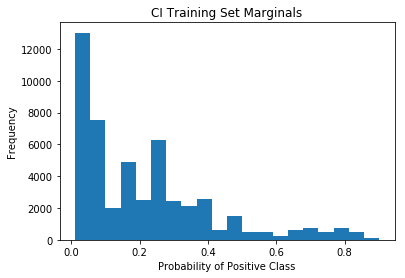

In [17]:
plt.hist(train_marginals_indep, bins=20)
plt.title("CI Training Set Marginals")
plt.ylabel("Frequency")
plt.xlabel("Probability of Positive Class")
plt.show()

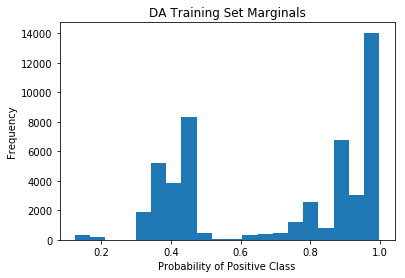

In [18]:
plt.hist(train_marginals, bins=20)
plt.title("DA Training Set Marginals")
plt.ylabel("Frequency")
plt.xlabel("Probability of Positive Class")
plt.show()

# Training Set Statistics

Taking a closer look into the training set predictions, we can see how each label function individually performed. The two dataframes below contain the follwoing information: number of candidate sentences a label function has labeled (coverage), number of candidate sentences a label function agreed with another label function (overlaps), number of candidates a label function disagreed with another label function (conflicts), and lastly, the accuracy each label function has after training the generative model (Learned Acc).

In [19]:
indep_results_df = L_train.lf_stats(session, est_accs=indep_learned_stats_df['Accuracy'])
indep_results_df.head(2)

,j,Coverage,Overlaps,Conflicts,Learned Acc.
LF_HETNET_DISEASES,0,0.40212,0.40212,0.37272,0.637386
LF_HETNET_DOAF,1,0.16650,0.16650,0.15012,0.585770


In [20]:
results_df = L_train.lf_stats(session, est_accs=learned_stats_df['Accuracy'])
results_df.head(2)

,j,Coverage,Overlaps,Conflicts,Learned Acc.
LF_HETNET_DISEASES,0,0.40212,0.40212,0.37272,0.822227
LF_HETNET_DOAF,1,0.16650,0.16650,0.15012,0.710969


The following bar charts below depict the weights the generative model assigns to each label function. The conditional independent model relies heavily on LF_HETNET_ABSENT and LF_NO_CONCLUSION, while the dependancy aware model relies more on the database-backed label functions. Ultimately, the DA model emphasizes more postive labels compared to the CI model. 

In [21]:
test_df = pd.concat([
    results_df[["Learned Acc."]].assign(model="DA"),
    indep_results_df[["Learned Acc."]].assign(model="CI"), 
])
test_df = test_df.reset_index()
test_df.head(2)

,index,Learned Acc.,model
0,LF_HETNET_DISEASES,0.822227,DA
1,LF_HETNET_DOAF,0.710969,DA


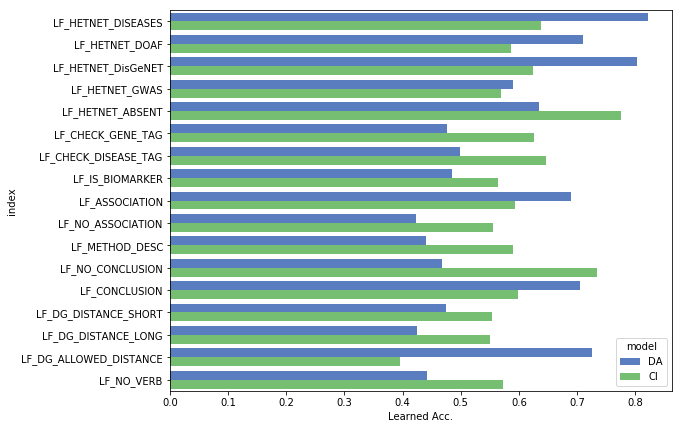

In [22]:
fig, ax = plt.subplots(figsize=(9,7))
sns.barplot(ax=ax,y="index", x="Learned Acc.", hue="model", data=test_df, palette=sns.color_palette("muted"))

## F1 Score of Dev Set

Moving from the training set, we now can look at how well these models can predict our small dev set. Looking at the chart below, the conditionally independent model doesn't perform well compared to the dependency aware model. In terms of f1 score there is about a .2 difference, which provides evidence towards the dependency model performing better.

In [23]:
_ = indep_gen_model.error_analysis(session, L_dev, dev_data_df.curated_dsh.apply(lambda x: -1 if x==0 else x).values)

Scores (Un-adjusted)
Pos. class accuracy: 0.123
Neg. class accuracy: 0.93
Precision            0.526
Recall               0.123
F1                   0.2
----------------------------------------
TP: 10 | FP: 9 | TN: 120 | FN: 71



In [24]:
tp, fp, tn, fn = gen_model.error_analysis(session, L_dev, dev_data_df.curated_dsh.apply(lambda x: -1 if x==0 else x).values)

Scores (Un-adjusted)
Pos. class accuracy: 0.704
Neg. class accuracy: 0.442
Precision            0.442
Recall               0.704
F1                   0.543
----------------------------------------
TP: 57 | FP: 72 | TN: 57 | FN: 24



In [25]:
L_dev_ci_marginals = indep_gen_model.marginals(L_dev)
L_dev_da_marginals = gen_model.marginals(L_dev)

In [26]:
dev_data_labels = dev_data_df.curated_dsh.replace({0:-1})

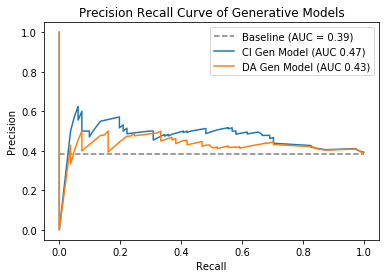

In [27]:
positive_class = dev_data_df.curated_dsh.values.sum()/dev_data_df.shape[0]
plt.plot([0,1], [positive_class, positive_class], color='grey', 
         linestyle='--', label='Baseline (AUC = {:0.2f})'.format(positive_class))

for marginal, model_label in zip([L_dev_ci_marginals, L_dev_da_marginals], ["CI Gen Model (AUC {:.2f})", "DA Gen Model (AUC {:.2f})"]):
    precision, recall, threshold = precision_recall_curve(dev_data_labels, marginal)
    area = auc(recall, precision)
    plt.plot(recall, precision, label=model_label.format(area))
plt.title("Precision Recall Curve of Generative Models")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()

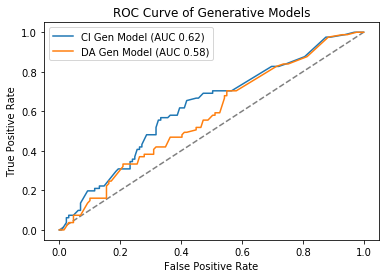

In [28]:
plt.plot([0,1], [0,1], linestyle='--', color='grey')
for marginal, model_label in zip([L_dev_ci_marginals, L_dev_da_marginals], ["CI Gen Model (AUC {:.2f})", "DA Gen Model (AUC {:.2f})"]):
    fpr, tpr, threshold = roc_curve(dev_data_labels, marginal)
    area = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=model_label.format(area))
plt.title("ROC Curve of Generative Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

In [29]:
L_dev.lf_stats(session, dev_data_labels, test_df.query("model=='DA'")["Learned Acc."])

/home/danich1/anaconda2/envs/snorkeling-test/lib/python3.6/site-packages/snorkel/annotations.py:137: RuntimeWarning: invalid value encountered in true_divide
  ac = (tp+tn) / (tp+tn+fp+fn)


,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.,Learned Acc.
LF_HETNET_DISEASES,0,0.428571,0.428571,0.380952,34,56,0,0,0.377778,0.822227
LF_HETNET_DOAF,1,0.180952,0.180952,0.171429,17,21,0,0,0.447368,0.710969
LF_HETNET_DisGeNET,2,0.414286,0.414286,0.380952,38,49,0,0,0.436782,0.803221
LF_HETNET_GWAS,3,0.042857,0.042857,0.042857,4,5,0,0,0.444444,0.590793
LF_HETNET_ABSENT,4,0.438095,0.438095,0.428571,0,0,32,60,0.652174,0.634251
LF_CHECK_GENE_TAG,5,0.304762,0.304762,0.300000,0,0,17,47,0.734375,0.476693
LF_CHECK_DISEASE_TAG,6,0.309524,0.309524,0.304762,0,0,22,43,0.661538,0.498685
LF_IS_BIOMARKER,7,0.019048,0.019048,0.014286,2,2,0,0,0.500000,0.484252
LF_ASSOCIATION,8,0.133333,0.133333,0.090476,17,11,0,0,0.607143,0.689563
LF_NO_ASSOCIATION,9,0.009524,0.009524,0.009524,0,0,1,1,0.500000,0.422460


# F1 Score of Train Hand Labeled Set

Looking at the small hand labeled training set we can see a pretty big spike in performance. In terms of f1 score the DA model has about a 0.25 increase in performance comapred to the CI model. 

In [30]:
_ = indep_gen_model.error_analysis(session, L_train_labeled, L_train_labeled_gold)

Scores (Un-adjusted)
Pos. class accuracy: 0.271
Neg. class accuracy: 0.928
Precision            0.781
Recall               0.271
F1                   0.403
----------------------------------------
TP: 121 | FP: 34 | TN: 439 | FN: 325



In [31]:
tp, fp, tn, fn = gen_model.error_analysis(session, L_train_labeled, L_train_labeled_gold)

Scores (Un-adjusted)
Pos. class accuracy: 0.993
Neg. class accuracy: 0.0211
Precision            0.489
Recall               0.993
F1                   0.655
----------------------------------------
TP: 443 | FP: 463 | TN: 10 | FN: 3



In [32]:
L_train_ci_marginals = indep_gen_model.marginals(L_train_labeled)
L_train_da_marginals = gen_model.marginals(L_train_labeled)

In [33]:
positive_class = sum(list(map(lambda x: 0 if x == -1 else x, L_train_labeled_gold.toarray()[:,0])))
positive_class = positive_class/L_train_labeled_gold.shape[0]

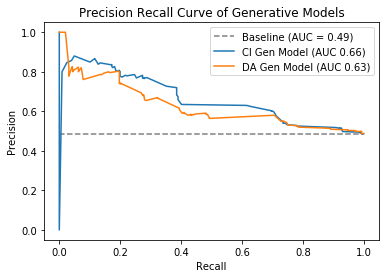

In [34]:
plt.plot([0,1], [positive_class, positive_class], color='grey', 
         linestyle='--', label='Baseline (AUC = {:0.2f})'.format(positive_class))

for marginal, model_label in zip([L_train_ci_marginals, L_train_da_marginals], ["CI Gen Model (AUC {:.2f})", "DA Gen Model (AUC {:.2f})"]):
    precision, recall, threshold = precision_recall_curve(L_train_labeled_gold.data, marginal)
    area = auc(recall, precision)
    plt.plot(recall, precision, label=model_label.format(area))
plt.title("Precision Recall Curve of Generative Models")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()

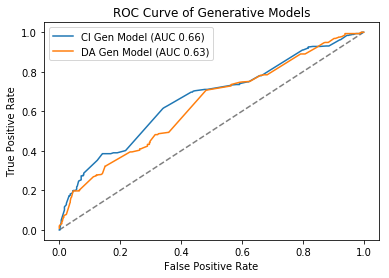

In [35]:
plt.plot([0,1], [0,1], linestyle='--', color='grey')
for marginal, model_label in zip([L_train_ci_marginals, L_train_da_marginals], ["CI Gen Model (AUC {:.2f})", "DA Gen Model (AUC {:.2f})"]):
    fpr, tpr, threshold = roc_curve(L_train_labeled_gold.data, marginal)
    area = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=model_label.format(area))
plt.title("ROC Curve of Generative Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

In [36]:
L_train_labeled.lf_stats(session, L_train_labeled_gold.data, test_df.query("model=='DA'")["Learned Acc."])

/home/danich1/anaconda2/envs/snorkeling-test/lib/python3.6/site-packages/snorkel/annotations.py:137: RuntimeWarning: invalid value encountered in true_divide
  ac = (tp+tn) / (tp+tn+fp+fn)


,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.,Learned Acc.
LF_HETNET_DISEASES,0,0.828074,0.828074,0.754081,383,378,0,0,0.503285,0.822227
LF_HETNET_DOAF,1,0.060936,0.060936,0.059848,30,26,0,0,0.535714,0.710969
LF_HETNET_DisGeNET,2,0.371055,0.371055,0.353645,156,185,0,0,0.457478,0.803221
LF_HETNET_GWAS,3,0.000000,0.000000,0.000000,0,0,0,0,NaN,0.590793
LF_HETNET_ABSENT,4,0.016322,0.016322,0.015234,0,0,4,11,0.733333,0.634251
LF_CHECK_GENE_TAG,5,0.157780,0.157780,0.157780,0,0,59,86,0.593103,0.476693
LF_CHECK_DISEASE_TAG,6,0.429815,0.429815,0.428727,0,0,178,217,0.549367,0.498685
LF_IS_BIOMARKER,7,0.082699,0.082699,0.040261,61,15,0,0,0.802632,0.484252
LF_ASSOCIATION,8,0.115343,0.115343,0.069641,82,24,0,0,0.773585,0.689563
LF_NO_ASSOCIATION,9,0.009793,0.009793,0.009793,0,0,6,3,0.333333,0.422460


## Individual Candidate Error Analysis

Depending on which block of code is executed, the following block of code below will show which candidate sentence was incorrectly labeled. Right now the false negatives (fn) are being shown below but this could change to incorporate false positives (fp) as well.

In [ ]:
from snorkel.viewer import SentenceNgramViewer

# NOTE: This if-then statement is only to avoid opening the viewer during automated testing of this notebook
# You should ignore this!
import os
if 'CI' not in os.environ:
    sv = SentenceNgramViewer(fn, session)
else:
    sv = None

In [ ]:
sv

In [ ]:
c = sv.get_selected() if sv else list(fp.union(fn))[0]
c

In [ ]:
c.labels

In [ ]:
c.id

In [ ]:
L_train_hand_labeled

## Generate Excel File of Train Data

Lastly we write out the generative model's output into a file. Reason for this will be used in the [next notebook](4.sentence-level-prediction.ipynb), where we aim to use a noise aware discriminator model to correct for the generative models' errors.

In [ ]:
def make_sentence_df(lf_matrix, marginals, pair_df):
    rows = list()
    for i in tqdm.tqdm(range(lf_matrix.shape[0])):
        row = OrderedDict()
        candidate = lf_matrix.get_candidate(session, i)
        row['candidate_id'] = candidate.id
        row['disease'] = candidate[0].get_span()
        row['gene'] = candidate[1].get_span()
        row['doid_id'] = candidate.Disease_cid
        row['entrez_gene_id'] = candidate.Gene_cid
        row['sentence'] = candidate.get_parent().text
        row['label'] = marginals[i]
        rows.append(row)
    sentence_df = pd.DataFrame(rows)
    sentence_df['entrez_gene_id'] = sentence_df.entrez_gene_id.astype(int)
    sentence_df = pd.merge(
        sentence_df,
        pair_df[["doid_id", "entrez_gene_id", "doid_name", "gene_symbol"]],
        on=["doid_id", "entrez_gene_id"],
        how="left"
    )
    sentence_df = pd.concat([
        sentence_df,
        pd.DataFrame(lf_matrix.todense(), columns=list(LFS))
    ], axis='columns')
    return sentence_df

In [ ]:
pair_df = pd.read_csv("data/disease-gene-pairs-association.csv.xz", compression='xz')
pair_df.head(2)

In [ ]:
train_sentence_df = make_sentence_df(L_train, train_marginals, pair_df)
train_sentence_df.head(2)

In [ ]:
writer = pd.ExcelWriter('data/sentence-labels.xlsx')
(train_sentence_df
    .to_excel(writer, sheet_name='sentences', index=False)
)
if writer.engine == 'xlsxwriter':
    for sheet in writer.sheets.values():
        sheet.freeze_panes(1, 0)
writer.close()

## Generate Excel File of Dev Data

In [ ]:
dev_sentence_df = make_sentence_df(L_dev, dev_marginals, pair_df)
dev_sentence_df.head(2)

In [ ]:
writer = pd.ExcelWriter('data/sentence-labels-dev.xlsx')
(dev_sentence_df
    .sample(frac=1, random_state=100)
    .to_excel(writer, sheet_name='sentences', index=False)
)
if writer.engine == 'xlsxwriter':
    for sheet in writer.sheets.values():
        sheet.freeze_panes(1, 0)
writer.close()